In [17]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import MathOptInterface as MOI
import Ipopt 
using LinearAlgebra
import ForwardDiff as FD
using Random
using Printf
Pkg.add("Plots")
using Plots

  Activating environment at `~/CMU/16745 OCRL/CMU-16745-Project/Project.toml`
    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
   Installed RecipesPipeline ─ v0.6.12
   Installed PlotUtils ─────── v1.3.5
   Installed Latexify ──────── v0.16.0
   Installed Plots ─────────── v1.38.11
   Installed GR_jll ────────── v0.72.4+0
   Installed PrecompileTools ─ v1.1.0
   Installed GR ────────────── v0.72.4
   Installed ColorSchemes ──── v3.21.0
    Updating `~/CMU/16745 OCRL/CMU-16745-Project/Project.toml`
  [91a5bcdd] + Plots v1.38.11
    Updating `~/CMU/16745 OCRL/CMU-16745-Project/Manifest.toml`
  [35d6a980] + ColorSchemes v3.21.0
  [c3611d14] + ColorVectorSpace v0.9.10
  [d38c429a] + Contour v0.6.2
  [59287772] + Formatting v0.4.2
  [28b8d3ca] + GR v0.72.4
  [42e2da0e] + Grisu v1.0.2
  [1019f520] + JLFzf v0.1.5
  [23fbe1c1] + Latexify v0.16.0
  [442fdcdd] + Measures v0.3.2
  [b98c9c47] + Pipe v1.3.0
  [ccf2f8ad] + PlotThemes v3.1.0
  [995b91a9] + PlotU

In [2]:
include(joinpath(@__DIR__, "utils","quadrotor.jl"))
    
function discrete_dynamics(params::NamedTuple, x::Vector, u)
    # discrete dynamics
    # x - state 
    # u - control
    # dt comes from params.model.dt 
    return rk4(params.model, quad_payload_dynamics, x, u, params.model.dt)
end

discrete_dynamics (generic function with 1 method)

In [5]:
function skew(ω::Vector)
    return [0    -ω[3]  ω[2];
            ω[3]  0    -ω[1];
           -ω[2]  ω[1]  0]
end

function quad_payload_dynamics(model, x,u)
    L_p = model.L_p
    m_p = model.mass_payload
    m_q = model.mass_quad
    J = model.J
    g = model.gravity
    kf = model.kf
    km = model.km
    ℓ = model.ℓ
    
    r_q = x[1:3]
    q = x[4:6]
    r_l = x[7:8]
    v_l = x[9:10]
    v_q = x[11:13]
    ω = x[14:16]
    
    ṙ_q = v_q
    q̇ = ((1+norm(q)^2)/4) *(I + 2*(skew(q)^2 + skew(q))/(1+norm(q)^2))*ω
    ṙ_l = v_l
        
    B = [I; -r_l' / sqrt(L_p - r_l'*r_l)]
    
    R_ib = dcm_from_mrp(q)' # Rotation from body to world frame '
    
    # Calculate Control Thrust and Torques
    F1 = max(0,kf*u[1])
    F2 = max(0,kf*u[2])
    F3 = max(0,kf*u[3])
    F4 = max(0,kf*u[4])
    F_b = [0.; 0.; F1+F2+F3+F4] #total rotor force in body frame
    F = -R_ib * F_b # negative since z axis in body frame is down
    
    M1 = km*u[1]
    M2 = km*u[2]
    M3 = km*u[3]
    M4 = km*u[4]
    M_b = [ℓ*(F3-F1), ℓ*(F2-F4), (M1-M2+M3-M4)] #total rotor torque in body frame
    # paper has two extra terms one for air drag (we ignore) and another for gyroscopic torque
    # Zac seems to ignore gyroscopic but not sure why
            
    
    # TODO: double check Ḃ (I plugged in the scalar form into wolfram alpha and took the derivative)
    Ḃ = [0 0; 0 0; L_p^2 * v_l' / (L_p^2 - r_l' * r_l)^(3/2)]
    ω_skew = skew(ω)

    RHS = [m_p * B' * g; (m_q + m_p) * g; zeros(3)] + [zeros(2); F; M_b]    
    Const = [-m_p * B' * Ḃ * v_l; m_p * Ḃ * v_l; ω_skew * J * ω]

    A = zeros(eltype(x), 8,8)
    A[1:2, :] = [m_p*B'*B m_p*B' zeros(2,3)]
    A[3:5, :] = [m_p*B (m_q+m_p)*I(3) zeros(3,3)]
    A[6:8, :] = [zeros(3,5) J]

    derivs = A \ (RHS - Const)
    
    return [ṙ_q; q̇; ṙ_l; derivs]
end

quad_payload_dynamics (generic function with 1 method)

In [6]:
# starter code: feel free to use or not use 

function stage_cost(p::NamedTuple,x::Vector,u::Vector,k::Int)
    return 0.5 * (x[k] - p.Xref[k])' * p.Q * (x[k] - p.Xref[k]) + 1/2 * (u[k] - p.Uref[k])' * p.R * (u[k] - p.Uref[k])
end
function term_cost(p::NamedTuple,x)
    return 0.5 * (x - p.Xref[p.N])' * p.Qf * (x - p.Xref[p.N])
end
function stage_cost_expansion(p::NamedTuple, x::Vector, u::Vector, k::Int)
    ∇ₓ²J = p.Q
    ∇ₓJ = p.Q * (x[k] - p.Xref[k])
    ∇ᵤ²J = p.R
    ∇ᵤJ = p.R * (u[k] - p.Uref[k])
    
    return [∇ₓ²J, ∇ₓJ, ∇ᵤ²J, ∇ᵤJ]

end
function term_cost_expansion(p::NamedTuple, x::Vector)
    ∇ₓ²Jn = p.Qf
    ∇ₓJn = p.Qf * (x - p.Xref[p.N])
    
    return [∇ₓ²Jn, ∇ₓJn]

end
function backward_pass(params::NamedTuple,          # useful params 
                       X::Vector{Vector{Float64}},  # state trajectory 
                       U::Vector{Vector{Float64}})  # control trajectory 
    # compute the iLQR backwards pass given a dynamically feasible trajectory X and U
    # return d, K, ΔJ  
    
    # outputs:
    #     d  - Vector{Vector} feedforward control  
    #     K  - Vector{Matrix} feedback gains 
    #     ΔJ - Float64        expected decrease in cost 
    
    nx, nu, N = params.nx, params.nu, params.N 
    
    # vectors of vectors/matrices for recursion 
    P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
    p = [zeros(nx)    for i = 1:N]   # cost to go linear term
    d = [zeros(nu)    for i = 1:N-1] # feedforward control
    K = [zeros(nu,nx) for i = 1:N-1] # feedback gain

    # TODO: implement backwards pass and return d, K, ΔJ 
    N = params.N
    ΔJ = 0.0
    
    # First p/P comes from terminal state
    P[N], p[N] = term_cost_expansion(params, X[N])
    
    for k = N - 1:-1:1
        ∇ₓ²J, ∇ₓJ, ∇ᵤ²J, ∇ᵤJ = stage_cost_expansion(params, X, U, k)
        Aₖ = FD.jacobian(dx -> discrete_dynamics(params, dx, U[k]), X[k])
        Bₖ = FD.jacobian(du -> discrete_dynamics(params, X[k], du), U[k])
        
        # Compute the g's and G's
        gₓ = ∇ₓJ + Aₖ' * p[k + 1]
        gᵤ = ∇ᵤJ + Bₖ' * p[k + 1]
        
        #iLQR (Gauss-Newton) version
        Gₓₓ = ∇ₓ²J + Aₖ' * P[k + 1] * Aₖ
        Gᵤᵤ = ∇ᵤ²J + Bₖ' * P[k + 1] * Bₖ
        Gₓᵤ = Aₖ' * P[k + 1] * Bₖ
        Gᵤₓ = Bₖ' * P[k + 1] * Aₖ
        
        d[k] = Gᵤᵤ \ gᵤ
        K[k] = Gᵤᵤ \ Gᵤₓ
        
        P[k] = Gₓₓ + K[k]' * Gᵤᵤ * K[k] - Gₓᵤ*K[k] - K[k]' * Gᵤₓ
        
        p[k] = gₓ - K[k]' * gᵤ + K[k]' * Gᵤᵤ * d[k] - Gₓᵤ * d[k]
        
        ΔJ += gᵤ'*d[k]
    end

    return d, K, ΔJ
end

function trajectory_cost(params::NamedTuple,          # useful params 
                         X::Vector{Vector{Float64}},  # state trajectory 
                         U::Vector{Vector{Float64}}) # control trajectory 
    # compute the trajectory cost for trajectory X and U (assuming they are dynamically feasible)
    N = params.N
    total_cost = term_cost(params, X[N])

    for i = 1:N-1
        total_cost += stage_cost(params, X, U, i)
    end
    
    return total_cost
end

function forward_pass(params::NamedTuple,           # useful params 
                      X::Vector{Vector{Float64}},   # state trajectory 
                      U::Vector{Vector{Float64}},   # control trajectory 
                      d::Vector{Vector{Float64}},   # feedforward controls 
                      K::Vector{Matrix{Float64}};   # feedback gains
                      max_linesearch_iters = 20)    # max iters on linesearch 
    # forward pass in iLQR with linesearch 
    # use a line search where the trajectory cost simply has to decrease (no Armijo)
    
    # outputs:
    #     Xn::Vector{Vector}  updated state trajectory  
    #     Un::Vector{Vector}  updated control trajectory 
    #     J::Float64          updated cost  
    #     α::Float64.         step length 

    nx, nu, N = params.nx, params.nu, params.N 
    
    Xn = [zeros(nx) for i = 1:N]      # new state history 
    Un = [zeros(nu) for i = 1:N-1]    # new control history 
    
    # initial condition 
    Xn[1] = 1*X[1]
    
    # initial step length 
    α = 1.0
    orig_traj_cost = trajectory_cost(params, X, U)
    
    for i = 1:max_linesearch_iters
        
        # Compute rollout
        for k = 1:N-1
            Un[k] = U[k] - α * d[k] - K[k] * (Xn[k] - X[k])
            Xn[k + 1] = discrete_dynamics(params, Xn[k], Un[k])
        end
        
        α /= 2
        
        updated_cost = trajectory_cost(params, Xn, Un)
        
        if  updated_cost < orig_traj_cost
            return Xn, Un, updated_cost, α
        end
    end

    error("forward pass failed")
end

forward_pass (generic function with 1 method)

In [7]:
function iLQR(params::NamedTuple,         # useful params for costs/dynamics/indexing 
              x0::Vector,                 # initial condition 
              U::Vector{Vector{Float64}}; # initial controls 
              atol=1e-3,                  # convergence criteria: ΔJ < atol 
              max_iters = 250,            # max iLQR iterations 
              verbose = true)             # print logging
    
    # iLQR solver given an initial condition x0, initial controls U, and a 
    # dynamics function described by `discrete_dynamics`
    
    # return (X, U, K) where 
    # outputs:
    #     X::Vector{Vector} - state trajectory 
    #     U::Vector{Vector} - control trajectory 
    #     K::Vector{Matrix} - feedback gains K 

    # first check the sizes of everything
    @assert length(U) == params.N-1
    @assert length(U[1]) == params.nu
    @assert length(x0) == params.nx 

    nx, nu, N = params.nx, params.nu, params.N

    X = [zeros(nx) for i = 1:N]
    X[1] = x0
    
    # Compute rollout
    for k = 1:N-1
        X[k + 1] = discrete_dynamics(params, X[k], U[k])
    end

    for ilqr_iter = 1:max_iters
        
        d, K, ΔJ = backward_pass(params, X, U)
        
        X, U, J, α = forward_pass(params, X, U, d, K)
        
        # termination criteria 
        if ΔJ < atol 
            if verbose 
                @info "iLQR converged"
            end
            return X, U, K 
        end
        
        # ---------------logging -------------------
        if verbose
            dmax = maximum(norm.(d))
            if rem(ilqr_iter-1,10)==0
                @printf "iter     J           ΔJ        |d|         α         \n"
                @printf "-------------------------------------------------\n"
            end
            @printf("%3d   %10.3e  %9.2e  %9.2e  %6.4f    \n",
              ilqr_iter, J, ΔJ, dmax, α)
        end
        
    end
    error("iLQR failed")
end

iLQR (generic function with 1 method)

In [101]:
function create_reference(N, dt)
    # create reference trajectory for quadrotor 
    R = 6
#     r_q = x[1:3]
#     q = x[4:6]
#     r_l = x[7:8]
#     v_l = x[9:10]
#     v_q = x[11:13]
#     ω = x[14:16]

#     Xref = [ [R*cos(t);R*cos(t)*sin(t);1.2 + sin(t);zeros(13)] for t = range(-pi/2,3*pi/2, length = N)]
#     Xref = [ [t;sin(3 * t);1;zeros(13)] for t = range(-pi/2,3*pi/2, length = N)] # Sin wave
    Xref = [ [3 * cos(2 * t); 3 * sin(2 * t);t;zeros(13)] for t = range(0, 2 * pi, length = N)] # Helix
    
    for i = 1:(N-1)
        Xref[i][11:13] = (Xref[i+1][1:3] - Xref[i][1:3])/dt
    end
    Xref[N][11:13] = Xref[N-1][11:13]
    Uref = [(9.81*1/4)*ones(4) for i = 1:(N-1)]
    return Xref, Uref
end

function solve_quadrotor_trajectory(;verbose = true)
    
    # problem size 
    nx = 16
    nu = 4
    dt = 0.05
    tf = 10
    t_vec = 0:dt:tf 
    N = length(t_vec)
    
    # tracking cost function
    Q = 1*diagm([.1*ones(3);.1*ones(3); 10*ones(2); .1*ones(2);1*ones(3);.1*ones(3)])
    R = .1*diagm(ones(nu))
    Qf = 10*Q 
    
    println(N)

    # dynamics parameters (these are estimated)
    model = (mass_quad=0.5,
        mass_payload=0.5,
        ℓ = 0.1750, # Quad radius
        L_p = 1, # Pendulum length
        J=Diagonal([0.0023, 0.0023, 0.004]),
        gravity=[0;0;9.81],
        kf=1.0,
        km=0.0245, dt = dt)
    
    # create reference trajectory 
    Xref, Uref = create_reference(N, dt)
    
    # the params needed by iLQR 
    params = (
        N = N, 
        nx = nx, 
        nu = nu, 
        Xref = Xref, 
        Uref = Uref, 
        Q = Q, 
        R = R, 
        Qf = Qf, 
        model = model
    )

    # initial condition 
    x0 = 1*Xref[1]
    
    # initial guess controls 
    U = [(uref + .0001*randn(nu)) for uref in Uref]
    
    # solve with iLQR
    X, U, K = iLQR(params,x0,U;atol=1e-4,max_iters = 250,verbose = verbose)
    
    return X, U, K, t_vec, params
end

solve_quadrotor_trajectory (generic function with 1 method)

In [102]:
Xilqr, Uilqr, Kilqr, t_vec, params =  solve_quadrotor_trajectory(verbose = false);

201


In [103]:
import MeshCat as mc
using CoordinateTransformations, Rotations, Colors
using GeometryBasics
import RobotDynamics as RD
using StaticArrays

function set_mesh!(vis, length)
    
    quad_file = joinpath(@__DIR__, "utils/quadrotor.obj")
#     warehouse_file = joinpath(@__DIR__, "utils/pillars.STL")
    
#     warehouse_obj =  mc.MeshFileGeometry(warehouse_file)
    robot_obj = mc.MeshFileGeometry(quad_file)
    quad_mat = mc.MeshPhongMaterial(color=colorant"black")
    
    pole_mat = mc.MeshPhongMaterial(color=colorant"blue")
    mass_mat = mc.MeshPhongMaterial(color=colorant"red")
    pole = mc.Cylinder(mc.Point3f0(0,0,0),Point3f0(0,0,-length),0.01f0)
    mass = mc.HyperSphere(mc.Point3f0(0,0,0), 0.05f0)
    
#     mc.setobject!(vis["warehouse"], warehouse_obj)
    mc.setobject!(vis["quad"], robot_obj, quad_mat)
    mc.setobject!(vis["pole"], pole, pole_mat)
    mc.setobject!(vis["mass"], mass, mass_mat)
end
#Quaternion stuff
function hat(v)
    return [0 -v[3] v[2];
            v[3] 0 -v[1];
            -v[2] v[1] 0]
end
function L(q)
    s = q[1]
    v = q[2:4]
    L = [s    -v';
         v  s*I+hat(v)]
    return L
end
T = Diagonal([1; -ones(3)])
H = [zeros(1,3); I]
function qtoQ(q)
    return H'*T*L(q)*T*L(q)*H
end
function G(q)
    G = L(q)*H
end
function rptoq(ϕ)
    (1/sqrt(1+ϕ'*ϕ))*[1; ϕ]
end
function qtorp(q)
    q[2:4]/q[1]
end

function visualize!(vis, x::StaticVector)
    quad_rot_mat = dcm_from_mrp(x[4:6])

    quad_ned = x[1:3]
    mass_ned = [x[7] + quad_ned[1]; x[8] + quad_ned[2]; -sqrt(1^2 - x[7:8]' * x[7:8]) + quad_ned[3]]
    
    # Find rotation that points a vector from quad to mass
    up = [0;0;1]
    dir = quad_ned - mass_ned
    q = [0; cross(up, dir)]
    q[1] = sqrt(norm(up)^2 * norm(dir)^2) + dot(up, dir)
    q = normalize(q)
    pole_rot_mat = qtoQ(q)
    
    mc.settransform!(vis["quad"], compose(Translation(quad_ned...), LinearMap(quad_rot_mat)))
    mc.settransform!(vis["pole"], compose(Translation(quad_ned...), LinearMap(pole_rot_mat)))
    mc.settransform!(vis["mass"], compose(Translation(mass_ned...)))
    
end
function vis_traj!(vis, X; R = 0.1, color = mc.RGBA(1.0, 0.0, 0.0, 1.0))
    # visualize a trajectory expressed with X::Vector{Vector}
    for i = 1:(length(X)-1)
        a = X[i][1:3]
        b = X[i+1][1:3]
        
        quad_ned = X[i][1:3]
        mass_ned = [X[i][7] + quad_ned[1]; X[i][8] + quad_ned[2]; quad_ned[3] - sqrt(1^2 - X[i][7:8]' * X[i][7:8])]
        
        quad_ned2 = X[i+1][1:3]
        mass_ned2 = [X[i][7] + quad_ned2[1]; X[i+1][8] + quad_ned2[2]; quad_ned2[3] - sqrt(1^2 - X[i+1][7:8]' * X[i+1][7:8])]
    
        cyl = mc.Cylinder(mc.Point(mass_ned...), mc.Point(mass_ned2...), R)
        cyl2 = mc.Cylinder(mc.Point(quad_ned...), mc.Point(quad_ned2...), R)
        mc.setobject!(vis["trajectory"]["p"*string(i)], cyl, mc.MeshPhongMaterial(color=color))
        mc.setobject!(vis["trajectory2"]["p"*string(i)], cyl2, mc.MeshPhongMaterial(color=mc.RGBA(0.0, 1.0, 0.0, 1.0)))
    end
end

function vis_ref!(vis, Xref; R = 0.01, color = mc.RGBA(0.0, 0.0, 1.0, 1.0))
    # visualize a trajectory expressed with X::Vector{Vector}
    for i = 1:(length(Xref)-1)
        a = Xref[i][1:3] - [0;0;1]
        b = Xref[i+1][1:3] - [0;0;1]
        
        cyl = mc.Cylinder(mc.Point(a...), mc.Point(b...), R)
        mc.setobject!(vis["ref"]["p"*string(i)], cyl, mc.MeshPhongMaterial(color=color))
    end
end

function visualize!(vis, tf::Real, X)
    fps = Int(round((length(X)-1)/tf))
    anim = mc.Animation(fps)
    x_dim = size(X[1])[1]
            
    vis_traj!(vis, X; R = 0.01, color = mc.RGBA(1.0, 0.0, 0.0, 1.0))
    
    for (k,x) in enumerate(X)
        mc.atframe(anim, k) do
            x = X[k]
            visualize!(vis, SVector{x_dim}(x))
        end
    end
    mc.setanimation!(vis, anim)
end

visualize! (generic function with 2 methods)

In [104]:
vis = mc.Visualizer()
mc.render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8703


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8703))

In [105]:
set_mesh!(vis, 1)

x_dim = size(Xilqr[1])[1]
X1 = [SVector{x_dim}(x) for x in Xilqr];
visualize!(vis, t_vec[end], X1)

Xref, Uref = create_reference(201, 0.05)
vis_ref!(vis, Xref)

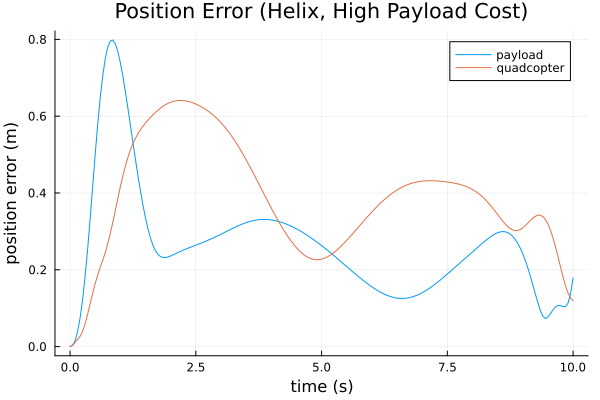

In [106]:
# Plots
ref_traj = "Helix"
high_cost = "Payload"
Xilqr_global = [[Xilqr[i][7] + Xilqr[i][1]; Xilqr[i][8] + Xilqr[i][2]; Xilqr[i][3] - sqrt(1^2 - Xilqr[i][7:8]' * Xilqr[i][7:8])] for i in 1:201]
mass_err = [norm(Xilqr_global[k]-(Xref[k][1:3]-[0;0;1])) for k in 1:201]
quad_err = [norm(Xilqr[k][1:3]-Xref[k][1:3]) for k in 1:201]
plot(t_vec, [mass_err quad_err], xlabel="time (s)", ylabel="position error (m)", title="Position Error (" * ref_traj * ", High "  * high_cost * " Cost)", label=["payload" "quadcopter"])
